In [1]:
%load_ext autoreload
# %aimport outer_spacem

%autoreload 1

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns

from outer_spacem.pl import plot_distributions, plot_umap_top_n, volcano_plot


# Pixel analysis part 4
# Open filtered AnnData, run clustering and do differential expression analysis  

## Set paths

### Input

`data_dir`: general root dir for storing data, including downloaded Metaspace datasets and plots  
`normalized_dataset_path`: path to the dataset, which was filtered and normalized as the first steps of single-cell analysis

### Output
`plots_path`: directory for plots  (ion images, cell masks, plots from scanpy analysis)  

In [2]:
data_dir = Path(r"/Users/alberto-mac/EMBL_ATeam/projects/gastrosome")

proj_dir = "Drug_W8_new_alyona"

plots_path = data_dir / proj_dir/ "plots" 
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path
plt.rcParams['savefig.facecolor']='white'

normalized_dataset_path = data_dir / proj_dir / "normalized_dataset.h5ad"
# normalized_dataset_path = data_dir / "single_cell_analysis" / "normalized_dataset_filter_low_ions.h5ad"

cond_col = "marked_cells"

## Open and view normalized dataset

In [3]:
adata = sc.read(normalized_dataset_path)

### Do differential expression analysis

Aim: find ions, which have different intensity in different clusters or groups of cells.  
There are tons of articles and tutorials about DE in RNAseq and scRNAseq, so I will only comment on the differences.

- In RNAseq data is descrete (counts) while in SpaceM data is continuous (intensity). In addition, it is not possible to measure intensities between 0 and some threshold (around 100 - 200 in raw ion intensity units), which results in kind of "truncated" distributions with large proportion of zeros for low-intensity ions. For small metabolite negative mode datasets most of intracellular ions have very low intensity. All this means that before using some complicated method designed for scRNAseq it's worth checking if statistical assumptions of the test are at least partially met.
- In Scanpy there are several methods for differential expression analysis. I think that since distributions are not normal in our case, the best option is using Wilcoxon test.
- Scanpy calculates fold change as median of intensity distribution for one condition divided by the median of the other condition. For ions with a lot of zeros it can give strange result, so I found it more useful to calculate fold change and do statistical testing only between non-zero part of distributions. It was done also for scRNAseq, with arguable (as always with DE testing) results.
- With Wilcoxon test any difference will be significant if we compare more than a thousand samples against another thousand, so all p-values will be super small and largely noninformative. Getting realistic p-values would require creating statistical test, which is based exactly on the distributions that we have. However, fold changes and p-values from Wilcoxon test are already sufficient to rank ions in some way.
- In the end after trying different options I arrived at a conclusion that it more or less doesn't matter, how exactly you do DE testing. But once you got top markers, it's important to check the following:
  - Intensity distributions really differ between conditions with the normalization that was chosen (all intensity distribtuions were plotted in the previous step) and it's not because of some outliers or something weird about how median was calculated
  - Checking ion in Metaspace shows that it is really intracellular, without strange gradients or missing parts in the ion image. Diagnostics should show that all the expected isotopic peaks are present and if intensity of the ion is high enough, isotopologue's spatial distribution looks colocalized with the main peak. If there is inconsistency between expected and observed isotopic peaks, it means that annotation is not reliable and it's better to be careful about interpreting its biological meaning 
  - Up or down regulation of the molecule corresponds to what is expected based on literature or bulk mass spec 

### Scanpy Wilcoxon test

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflo

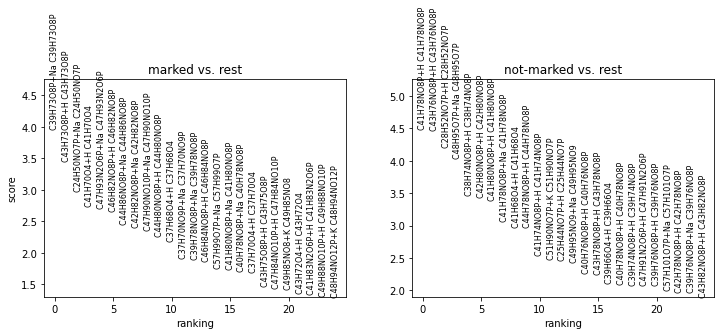

In [4]:
sc.tl.rank_genes_groups(adata, cond_col, method='wilcoxon', key_added = "wilcoxon", gene_symbols="var_names")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="wilcoxon", gene_symbols="var_names")

There are lots of different plots to [visualize results of DE](https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html)

### Save differential expression table

In [5]:
diff_expr_df = sc.get.rank_genes_groups_df(adata, None, key="wilcoxon", gene_symbols="var_names")

In [6]:
diff_expr_df = diff_expr_df.sort_values("pvals_adj", ascending=True)
diff_expr_df.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,var_names
344,marked,C41H78NO8P+H,-4.480712,-160.375107,0.000007,0.001312,C41H78NO8P+H C41H78NO8P
346,not-marked,C43H76NO8P+H,4.476066,126.653557,0.000008,0.001312,C43H76NO8P+H C43H76NO8P
345,not-marked,C41H78NO8P+H,4.480712,160.375107,0.000007,0.001312,C41H78NO8P+H C41H78NO8P
343,marked,C43H76NO8P+H,-4.476066,-126.653557,0.000008,0.001312,C43H76NO8P+H C43H76NO8P
347,not-marked,C28H52NO7P+H,4.211913,186.743805,0.000025,0.002912,C28H52NO7P+H C28H52NO7P


In [7]:
diff_expr_df.to_csv(plots_path / "diff_expr.csv", index=False)

## Volcano plot

Volcano plots are typically used to visualize results of DE analysis. It is a plot of $log_2(fold change)$ vs $-log_{10}(pval)$, so the plot shows how many ions were found to significantly change their abundance. Machine epsilon is added to each p-value to avoid $log(0)$ errors.  
Normally genes with small fold change should also have high p-value, because to detect small effect one needs big sample size, and genes with large change have lower p-values, creating "volcano" shape. Then the plot can be used to decide, what thresholds for significance and fold changes to use to identify ions of interest. Especially in our case statistical tests show that everything is significant, so one has to choose much lower threshold for p-values, than standard 0.05. Another useful thing to look at is if there are any outliers in fold changes.

/Users/alberto-mac/EMBL_repos/outer-spacem/outer_spacem/pl/_diff_expr.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group["significant"] = df_group["pvals_adj"] < pval_thresh
/Users/alberto-mac/EMBL_repos/outer-spacem/outer_spacem/pl/_diff_expr.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group["up"] = df_group["significant"] & (df_group["logfoldchanges"] > up_thresh)
/Users/alberto-mac/EMBL_repos/outer-spacem/outer_spacem/pl/_diff_expr.py:113: SettingWithCopyWarning: 
A value is tryi

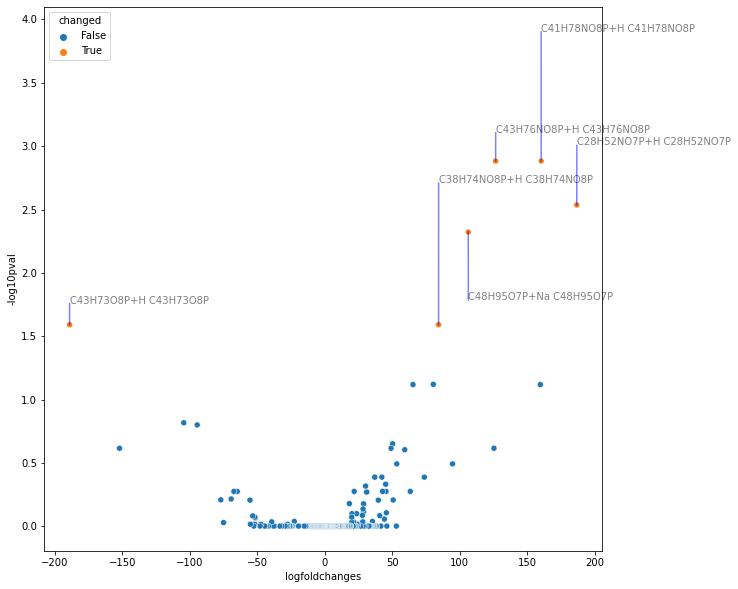

/Users/alberto-mac/EMBL_repos/outer-spacem/outer_spacem/pl/_diff_expr.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group["significant"] = df_group["pvals_adj"] < pval_thresh
/Users/alberto-mac/EMBL_repos/outer-spacem/outer_spacem/pl/_diff_expr.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_group["up"] = df_group["significant"] & (df_group["logfoldchanges"] > up_thresh)
/Users/alberto-mac/EMBL_repos/outer-spacem/outer_spacem/pl/_diff_expr.py:113: SettingWithCopyWarning: 
A value is tryi

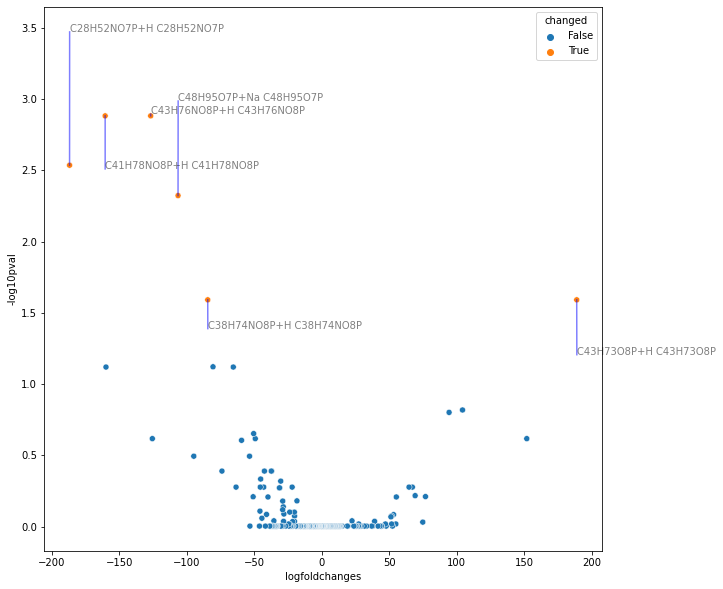

In [8]:
volcano_plot(adata, "wilcoxon",  plots_path, pval_thresh=0.05, foldch_thresh=2, gene_symbols="var_names")

### Plot ion intensity distribtuions per condition



In [9]:
dist_plots_path = plots_path / "intensity_distributions"
dist_plots_path.mkdir(parents=True, exist_ok=True)
plot_distributions(adata, cond_col, dist_plots_path, gene_symbols="var_names")

/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alberto-mac/miniconda3/envs/outerSpacem/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/Users/alberto-mac/miniconda